In [1]:
import pandas as pd
import geopandas as gpd
import shapely
import rasterio
import descartes

### Get geophysics survey metadata from Geoscience Australia web services

In [2]:
#thanks to Simon van der Wielen for the shortcut
surveys = pd.read_csv('https://services.ga.gov.au/gis/geophysical-surveys/wms?request=GetFeature&service=WFS&version=1.1.0&outputFormat=csv&typeName=gadds:geophysical_survey_datasets')

In [3]:
pd.set_option('display.max_columns', 100)

In [4]:
surveys.head()

,FID,datasetno,survey_eno,constituent_surveys,survey_id,survey_name,measure_type,measure_subtype,dataset_type,national_dataset,archive_file_description,archive_file_format,datum_levelling,archive_location,archive_type,file_size,country,state,onshore_offshore,survey_type,survey_detail,owner,operator,contractor,processor,client,platform_type,platform_name,survey_start_date,survey_end_date,crs_datum,min_longitude_wgs84,max_longitude_wgs84,min_latitude_wgs84,max_latitude_wgs84,min_line_spacing_m,max_line_spacing_m,tie_spacing_m,line_km,tie_km,total_km,line_azimuth,tie_azimuth,area_km2,flight_height_asl,flight_height_agl,mag_instrument,mag_sample_interval,rad_instrument,rad_sample_interval,rad_crystal_volume_down,rad_crystal_volume_up,grav_stations,min_station_spacing_m,max_station_spacing_m,grav_layout,grav_instrument,grav_reliability,em_system,legislation,survey_comments,cell_size_degrees,cell_size_m,dataset_release_date,licence,wms,wcs,ncss,opendap,file_download,doi,ecat_id,ecat_pid,ecat_uuid,dataset_qa_status,geometry
0,geophysical_survey_datasets.14601,14601,228803,NaN,1000,"Julia Creek, QLD, 1999",elevation,ground elevation geoid,grid,N,Julia Creek elevation grid geodetic,NetCDF (.nc),NaN,/g/data/iv65/Geoscience_Australia_Geophysics_R...,ANU NCI file repository,5395 KB,AUS,QLD,onshore,air,semi-detailed,Australian Geological Survey Organisation (AGSO),Australian Geological Survey Organisation (AGSO),Australian Geological Survey Organisation (AGS...,Australian Geological Survey Organisation (AGS...,NaN,fixed wing aircraft,Rockwell Aero Commander VH-BGE,1999-04-25,1999-06-06,EPSG:4326,140.9911,142.5110,-21.0119,-19.9845,400.0,400.0,4000.0,44849.0,4548.0,49397.0,90.0,0.0,17323.0,NaN,80.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0008,90.0,2020-09-01,CC BY 4.0 © Commonwealth of Australia (Geoscie...,NaN,NaN,NaN,NaN,http://dapds00.nci.org.au/thredds/fileServer/i...,NaN,140555.0,http://pid.geoscience.gov.au/dataset/ga/140555,073970ff-64e8-4cdd-a099-ad934acc6ebc,U,"POLYGON ((-21.008366 140.991649, -21.007188 14..."
1,geophysical_survey_datasets.14602,14602,228803,NaN,1000,"Julia Creek, QLD, 1999",radiometric,dose rate - terrestrial,grid,N,Julia Creek dose rate grid geodeticg,NetCDF (.nc),NaN,/g/data/iv65/Geoscience_Australia_Geophysics_R...,ANU NCI file repository,6251 KB,AUS,QLD,onshore,air,semi-detailed,Australian Geological Survey Organisation (AGSO),Australian Geological Survey Organisation (AGSO),Australian Geological Survey Organisation (AGS...,Australian Geological Survey Organisation (AGS...,NaN,fixed wing aircraft,Rockwell Aero Commander VH-BGE,1999-04-25,1999-06-06,EPSG:4326,140.9911,142.5110,-21.0120,-19.9845,400.0,400.0,4000.0,44849.0,4548.0,49397.0,90.0,0.0,17323.0,NaN,80.0,NaN,NaN,geoMetrics Exploranium GR-800,1.0 second,33.6 litre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0008,90.0,2020-09-01,CC BY 4.0 © Commonwealth of Australia (Geoscie...,NaN,NaN,NaN,NaN,http://dapds00.nci.org.au/thredds/fileServer/i...,NaN,142623.0,http://pid.geoscience.gov.au/dataset/ga/142623,e4765eca-c682-4fe4-a151-49c1ab4949a9,U,"POLYGON ((-21.008287 140.992593, -21.007313 14..."
2,geophysical_survey_datasets.14603,14603,228803,NaN,1000,"Julia Creek, QLD, 1999",radiometric,K equivalent ground concentration,grid,N,Julia Creek percent potassium grid geodeticg,NetCDF (.nc),NaN,/g/data/iv65/Geoscience_Australia_Geophysics_R...,ANU NCI file repository,6541 KB,AUS,QLD,onshore,air,semi-detailed,Australian Geological Survey Organisation (AGSO),Australian Geological Survey Organisation (AGSO),Australian Geological Survey Organisation (AGS...,Australian Geological Survey Organisation (AGS...,NaN,fixed wing aircraft,Rockwell Aero Commander VH-BGE,1999-04-25,1999-06-06,EPSG:4326,140.9911,142.5110,-21.0120,-19.9845,400.0,400.0,4000.0,44849.0,4548.0,49397.0,90.0,0.0,17323.0,NaN,80.0,NaN,NaN,geoMetrics Exploranium GR-800,1.0 second,33.6 litre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0008,90.0,2020-09-01,CC BY 4.0 © Commonwealth of Austral

In [5]:
surveys.measure_type.value_counts()

radiometric    1858
gravity        1825
magnetic       1271
elevation       576
Name: measure_type, dtype: int64

We just want the magnetic line surveys for now - according to the writeup, 1059 went into the national magnetic map grids, but at the moment we don't know which surveys, hopefully a list forthcoming soon

In [6]:
rad_surveys = surveys[surveys['measure_type'] == 'radiometric']

In [7]:
rad_surveys['dataset_type'].value_counts()

grid    1195
line     663
Name: dataset_type, dtype: int64

In [8]:
rad_surveys.head()

,FID,datasetno,survey_eno,constituent_surveys,survey_id,survey_name,measure_type,measure_subtype,dataset_type,national_dataset,archive_file_description,archive_file_format,datum_levelling,archive_location,archive_type,file_size,country,state,onshore_offshore,survey_type,survey_detail,owner,operator,contractor,processor,client,platform_type,platform_name,survey_start_date,survey_end_date,crs_datum,min_longitude_wgs84,max_longitude_wgs84,min_latitude_wgs84,max_latitude_wgs84,min_line_spacing_m,max_line_spacing_m,tie_spacing_m,line_km,tie_km,total_km,line_azimuth,tie_azimuth,area_km2,flight_height_asl,flight_height_agl,mag_instrument,mag_sample_interval,rad_instrument,rad_sample_interval,rad_crystal_volume_down,rad_crystal_volume_up,grav_stations,min_station_spacing_m,max_station_spacing_m,grav_layout,grav_instrument,grav_reliability,em_system,legislation,survey_comments,cell_size_degrees,cell_size_m,dataset_release_date,licence,wms,wcs,ncss,opendap,file_download,doi,ecat_id,ecat_pid,ecat_uuid,dataset_qa_status,geometry
1,geophysical_survey_datasets.14602,14602,228803,NaN,1000,"Julia Creek, QLD, 1999",radiometric,dose rate - terrestrial,grid,N,Julia Creek dose rate grid geodeticg,NetCDF (.nc),NaN,/g/data/iv65/Geoscience_Australia_Geophysics_R...,ANU NCI file repository,6251 KB,AUS,QLD,onshore,air,semi-detailed,Australian Geological Survey Organisation (AGSO),Australian Geological Survey Organisation (AGSO),Australian Geological Survey Organisation (AGS...,Australian Geological Survey Organisation (AGS...,NaN,fixed wing aircraft,Rockwell Aero Commander VH-BGE,1999-04-25,1999-06-06,EPSG:4326,140.9911,142.511,-21.0120,-19.9845,400.0,400.0,4000.0,44849.0,4548.0,49397.0,90.0,0.0,17323.0,NaN,80.0,NaN,NaN,geoMetrics Exploranium GR-800,1.0 second,33.6 litre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0008,90.0,2020-09-01,CC BY 4.0 © Commonwealth of Australia (Geoscie...,NaN,NaN,NaN,NaN,http://dapds00.nci.org.au/thredds/fileServer/i...,NaN,142623.0,http://pid.geoscience.gov.au/dataset/ga/142623,e4765eca-c682-4fe4-a151-49c1ab4949a9,U,"POLYGON ((-21.008287 140.992593, -21.007313 14..."
2,geophysical_survey_datasets.14603,14603,228803,NaN,1000,"Julia Creek, QLD, 1999",radiometric,K equivalent ground concentration,grid,N,Julia Creek percent potassium grid geodeticg,NetCDF (.nc),NaN,/g/data/iv65/Geoscience_Australia_Geophysics_R...,ANU NCI file repository,6541 KB,AUS,QLD,onshore,air,semi-detailed,Australian Geological Survey Organisation (AGSO),Australian Geological Survey Organisation (AGSO),Australian Geological Survey Organisation (AGS...,Australian Geological Survey Organisation (AGS...,NaN,fixed wing aircraft,Rockwell Aero Commander VH-BGE,1999-04-25,1999-06-06,EPSG:4326,140.9911,142.511,-21.0120,-19.9845,400.0,400.0,4000.0,44849.0,4548.0,49397.0,90.0,0.0,17323.0,NaN,80.0,NaN,NaN,geoMetrics Exploranium GR-800,1.0 second,33.6 litre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0008,90.0,2020-09-01,CC BY 4.0 © Commonwealth of Australia (Geoscie...,NaN,NaN,NaN,NaN,http://dapds00.nci.org.au/thredds/fileServer/i...,NaN,140554.0,http://pid.geoscience.gov.au/dataset/ga/140554,91645a29-7417-41d2-a7e9-caf8ba02d4d7,U,"POLYGON ((-21.008287 140.992593, -21.007313 14..."
3,geophysical_survey_datasets.14604,14604,228803,NaN,1000,"Julia Creek, QLD, 1999",radiometric,Th equivalent ground concentration,grid,N,Julia Creek ppm thorium grid geodetichg,NetCDF (.nc),NaN,/g/data/iv65/Geoscience_Australia_Geophysics_R...,ANU NCI file repository,6380 KB,AUS,QLD,onshore,air,semi-detailed,Australian Geological Survey Organisation (AGSO),Australian Geological Survey Organisation (AGSO),Australian Geological Survey Organisation (AGS...,Australian Geological Survey Organisation (AGS...,NaN,fixed wing aircraft,Rockwell Aero Commander VH-BGE,1999-04-25,1999-06-06,EPSG:4326,140.9911,142.511,-21.0120,-19.9845,400.0,400.0,4000.0,44849.0,4548.0,49397.0,90.0,0.0,17323.0,NaN,80.0,NaN,NaN,geoMetrics Exploranium GR-800,1.0 second,33.6 litre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0

Check if min and max line spacing are generally the same

In [9]:
rad_surveys_line = rad_surveys[rad_surveys['dataset_type'] == 'line']

In C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pygmt\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pygmt\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pygmt\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\rscott\AppData\Local\Continuum\anaconda3\envs\pygmt\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotli

<AxesSubplot:xlabel='min_line_spacing_m', ylabel='max_line_spacing_m'>

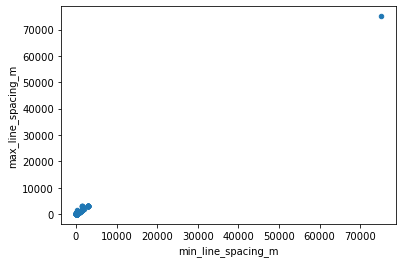

In [10]:
rad_surveys_line.plot.scatter('min_line_spacing_m','max_line_spacing_m')

It does appear that some have different values from survey combinations, etc

In [11]:
rad_surveys_line.sort_values(by='min_line_spacing_m', inplace=True)

<ipython-input-11-973f4f1285da>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rad_surveys_line.sort_values(by='min_line_spacing_m', inplace=True)


In [12]:
#which we see here
rad_surveys_line.head(10)

,FID,datasetno,survey_eno,constituent_surveys,survey_id,survey_name,measure_type,measure_subtype,dataset_type,national_dataset,archive_file_description,archive_file_format,datum_levelling,archive_location,archive_type,file_size,country,state,onshore_offshore,survey_type,survey_detail,owner,operator,contractor,processor,client,platform_type,platform_name,survey_start_date,survey_end_date,crs_datum,min_longitude_wgs84,max_longitude_wgs84,min_latitude_wgs84,max_latitude_wgs84,min_line_spacing_m,max_line_spacing_m,tie_spacing_m,line_km,tie_km,total_km,line_azimuth,tie_azimuth,area_km2,flight_height_asl,flight_height_agl,mag_instrument,mag_sample_interval,rad_instrument,rad_sample_interval,rad_crystal_volume_down,rad_crystal_volume_up,grav_stations,min_station_spacing_m,max_station_spacing_m,grav_layout,grav_instrument,grav_reliability,em_system,legislation,survey_comments,cell_size_degrees,cell_size_m,dataset_release_date,licence,wms,wcs,ncss,opendap,file_download,doi,ecat_id,ecat_pid,ecat_uuid,dataset_qa_status,geometry
957,geophysical_survey_datasets.15972,15972,228737,NaN,697,"West Wyalong Detail, NSW, 1998",radiometric,radiometric line data,line,N,"West Wyalong Detail, NSW, 1998 (P697), radiome...",NetCDF (.nc),AWAGS_RAD_2015,/g/data/iv65/Geoscience_Australia_Geophysics_R...,ANU NCI file repository,5048 KB,AUS,NSW,onshore,air,detailed,Australian Geological Survey Organisation (AGSO),Australian Geological Survey Organisation (AGSO),Australian Geological Survey Organisation (AGS...,Australian Geological Survey Organisation (AGSO),NaN,fixed wing aircraft,Rockwell Aero Commander VH-BGE,1998-11-10,1998-11-14,EPSG:4283,147.0540,147.3380,-33.9193,-33.6987,50.0,100.0,1000.0,7372.0,447.0,7819.0,90.0,0.0,385.0,NaN,60.0,NaN,NaN,geoMetrics Exploranium GR-820,1.0 second,33.3 litre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-01,CC BY 4.0 © Commonwealth of Australia (Geoscie...,NaN,NaN,NaN,NaN,http://dapds00.nci.org.au/thredds/fileServer/i...,NaN,141397.0,http://pid.geoscience.gov.au/dataset/ga/141397,ad5e2a8c-9284-4911-8c91-6e67a120037c,U,"POLYGON ((-33.866282 147.053907, -33.865533 14..."
3612,geophysical_survey_datasets.19593,19593,228926,NaN,864,"Wolfe Creek Crater, WA, 2002",radiometric,radiometric line data,line,N,"Wolfe Creek Crater, WA, 2002 (P864), radiometr...",NetCDF (.nc),NaN,/g/data/iv65/Geoscience_Australia_Geophysics_R...,ANU NCI file repository,387 KB,AUS,WA,onshore,air,detailed,Geological Survey of Western Australia (GSWA);...,Geological Survey of Western Australia (GSWA);...,UTS Geophysics Pty Ltd,Baigent Geosciences Pty Ltd,NaN,fixed wing aircraft,Fletcher FU24-954 VH-HVP,2002-07-19,2002-07-19,EPSG:4283,127.7753,127.8168,-19.1920,-19.1523,50.0,50.0,500.0,35.0,367.0,402.0,0.0,NaN,16.0,NaN,40.0,NaN,NaN,geoMetrics Exploranium GR-820,1.0 second,33.6 litre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-09-01,CC BY 4.0 © Commonwealth of Australia (Geoscie...,NaN,NaN,NaN,NaN,http://dapds00.nci.org.au/thredds/fileServer/i...,NaN,142691.0,http://pid.geoscience.gov.au/dataset/ga/142691,660f310d-da82-447c-b628-362e9fd94f50,U,"POLYGON ((-19.184557 127.775006, -19.160271 12..."
2219,geophysical_survey_datasets.17622,17622,606678,NaN,1292,Isa Region Airborne Magnetic Radiometric and D...,radiometric,radiometric line data,line,N,"GSQ Isa Region Cloncurry, 2017 (P1292), radiom...",NetCDF (.nc),NaN,/g/data/iv65/Geoscience_Australia_Geophysics_R...,ANU NCI file repository,74195 KB,AUS,QLD,onshore,air,NaN,Geological Survey of Queensland (GSQ),NaN,GPX Surveys Pty Ltd,GPX Surveys Pty Ltd,Geological Survey of Queensland (GSQ),fixed wing aircraft,Cessna 210L Centurion VH-IBY,2017-07-10,2018-04-30,EPSG:4283,140.2279,141.0319,-22.0037,-20.5769,50.0,100.0,NaN,103119.0,10268.0,113387.0,90.0,0.0,10475.0,NaN,50.0,NaN,NaN,unknown,1.0 second,32.0 litre,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Survey has two blocks - Mary Kathleen and the ...,NaN,NaN,2020-09-01,CC BY 4.0 © Geological Survey of Queensland,NaN,NaN,NaN,NaN,http://dapds00.nci.or

So we will use the max line spacing as an indicator

Next, we need to turn this text dataset into a geospatial dataset

In [13]:
type(rad_surveys_line['geometry'])

pandas.core.series.Series

In [16]:
rad_surveys_line['geometry'].iloc[1]

'POLYGON ((-19.184557 127.775006, -19.160271 127.774928, -19.152522 127.776351, -19.151875 127.77866, -19.152546 127.816184, -19.157678 127.817133, -19.174284 127.817144, -19.179456 127.816485, -19.187765 127.816823, -19.192264 127.815494, -19.191891 127.776606, -19.188439 127.775077, -19.184557 127.775006))'

In [22]:
#fix the geometry from text
from shapely import wkt
rad_surveys_line['geometry'] = rad_surveys_line['geometry'].apply(wkt.loads)

<ipython-input-22-884218824c22>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rad_surveys_line['geometry'] = rad_surveys_line['geometry'].apply(wkt.loads)


In [23]:
gdf = gpd.GeoDataFrame(rad_surveys_line, crs = "EPSG:4283", geometry=rad_surveys_line['geometry'])

<AxesSubplot:>

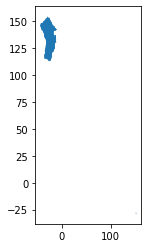

In [24]:
gdf.plot()

In [25]:
gdf.total_bounds

array([-43.914208, -28.963778, 152.309751, 154.687161])

In [26]:
#correct the coordinates
gdf.geometry = gdf.geometry.map(lambda polygon: shapely.ops.transform(lambda x, y: (y, x), polygon))

<AxesSubplot:>

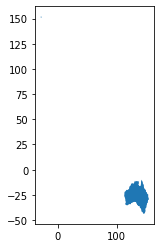

In [27]:
gdf.plot()

In [28]:
gdf.total_bounds

array([-28.963778, -43.914208, 154.687161, 152.309751])

In [29]:
#set crs
gdf.crs = "EPSG:4283"

In [30]:
gdf = gdf.to_crs("EPSG:4326")

In [31]:
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Sort descending so that the lowest value for a given part of a polygon is used in rasterizing

In [32]:
gdf.sort_values(by='max_line_spacing_m', inplace=True, ascending=False)

In [33]:
gdf['max_line_spacing_m'].head(10)

308    75000.0
627     3000.0
619     3000.0
577     3000.0
508     3000.0
677     3000.0
669     3000.0
617     3000.0
655     3000.0
553     3000.0
Name: max_line_spacing_m, dtype: float64

In [34]:
gdf['max_line_spacing_m'].value_counts()

400.0      308
1500.0      86
500.0       75
200.0       70
250.0       39
3000.0      22
100.0       21
300.0       10
800.0        9
1000.0       6
150.0        5
1600.0       4
125.0        3
50.0         2
750.0        1
2000.0       1
75000.0      1
Name: max_line_spacing_m, dtype: int64

Organise to limit to the Australian area of interest, and output

In [35]:
from rasterio.features import rasterize
col = 'max_line_spacing_m'
with rasterio.open(r'model_raster.tif') as src:
    print(src.bounds)
    print(src.meta)
    shapes = ((geom,value) for geom, value in zip(gdf.geometry, gdf[col]))
    
    varray = rasterize(shapes,
                   out_shape=(src.height, src.width),
                   transform=src.transform,
                   all_touched=True,
                   dtype='float32')
    
    with rasterio.open('rad_surveys_line_quality.tif', 'w', **src.meta) as dst:
        dst.write(varray, indexes=1)
    

BoundingBox(left=113.0, bottom=-44.0, right=154.0, top=-10.0)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 5087, 'height': 4710, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008059760172989974, 0.0, 113.0,
       0.0, -0.007218683651804671, -10.0)}


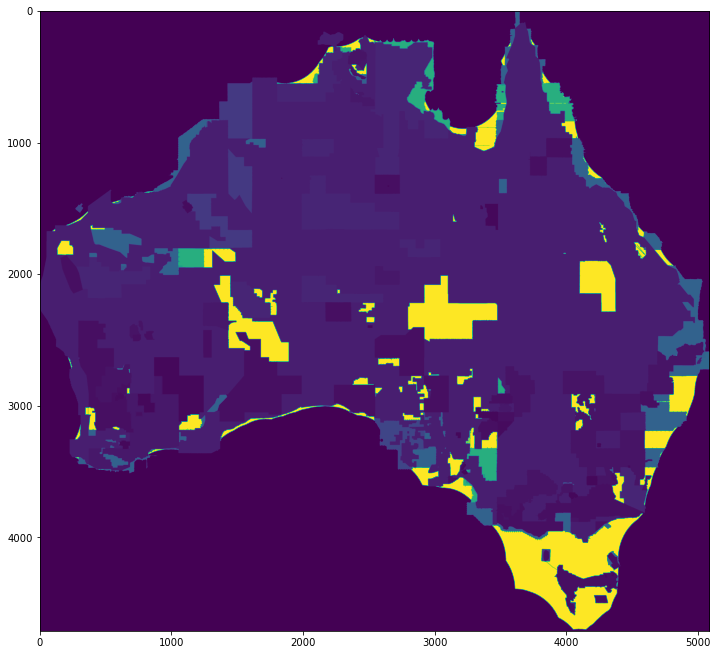

In [36]:
#clip to 4800 to remove influence of the outlier

from rasterio.plot import show, show_hist
from matplotlib import pyplot
pyplot.figure(figsize=(12,12))
pyplot.imshow(varray.clip(max=4800), cmap="viridis")
pyplot.show()

Show data distribution

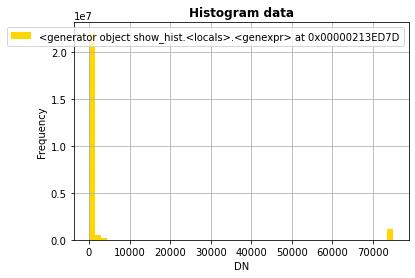

In [37]:
show_hist(source=varray, bins=50, title='Histogram data',histtype='stepfilled')

Repeating for minimum line spacing

In [38]:
gdf.sort_values(by='min_line_spacing_m', inplace=True, ascending=False)

In [39]:
gdf['min_line_spacing_m'].value_counts()

400.0      247
200.0      121
1500.0      90
500.0       55
250.0       48
100.0       32
300.0       20
3000.0      18
150.0        8
50.0         5
800.0        5
1000.0       5
125.0        3
1600.0       3
750.0        1
2000.0       1
75000.0      1
Name: min_line_spacing_m, dtype: int64

In [40]:
from rasterio.features import rasterize
col = 'min_line_spacing_m'
with rasterio.open(r'model_raster.tif') as src:
    print(src.bounds)
    print(src.meta)
    shapes = ((geom,value) for geom, value in zip(gdf.geometry, gdf[col]))
    
    varray = rasterize(shapes,
                   out_shape=(src.height, src.width),
                   transform=src.transform,
                   all_touched=True,
                   dtype='float32')
    
    with rasterio.open('rad_surveys_line_quality_min.tif', 'w', **src.meta) as dst:
        dst.write(varray, indexes=1)


BoundingBox(left=113.0, bottom=-44.0, right=154.0, top=-10.0)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 5087, 'height': 4710, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.008059760172989974, 0.0, 113.0,
       0.0, -0.007218683651804671, -10.0)}


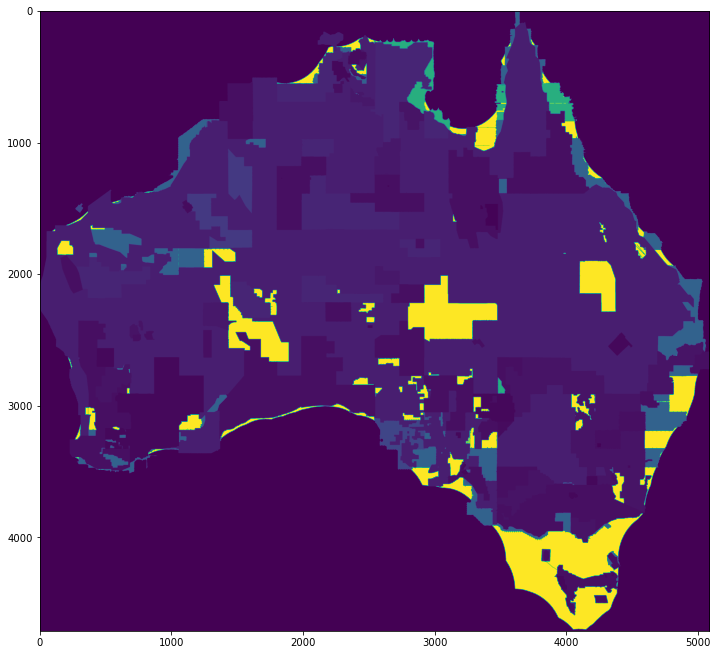

In [41]:
#clip to 4800 to remove influence of the outlier

from rasterio.plot import show, show_hist
from matplotlib import pyplot
pyplot.figure(figsize=(12,12))
pyplot.imshow(varray.clip(max=4800), cmap="viridis")
pyplot.show()

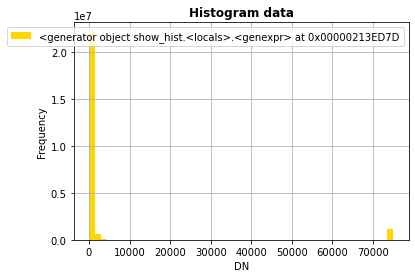

In [42]:
show_hist(source=varray, bins=50, title='Histogram data',histtype='stepfilled')